In [14]:
#%matplotlib widget

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

from Wine_Quality.custom_funcs import MultipleFisherDiscriminantAnalysis as MDA

# INTRODUZIONE

Il Wine Quality è una raccolta di due datasets (red_wine e white_wine) presente nella UCI machine learning repository.

I vari attributi che compongono i due datasets sono i risultati di test chimico-fisici e sensoriali effettuati su campioni di vinho verde portoghese, volti a determinarne la qualità. 

I vini vengono infatti divisi, tramite l' attributo 'quality' in 10 classi (da 1 a 10), ciascuna delle quali rappresenta un diverso grado di eccellenza. Tanto più alto è il numero della classe di appartenza di un campione di vino e tanto maggiore è il suo valore.

# IMPORTAZIONE DATABASE REDWINE

Si inizia con l' importare il primo database, rinominando le colonne e assicurandoci che i valori siano importati correttamente.

In [15]:
red_wine = pd.read_csv('../data/cleaned/winequality-red.csv', sep=';', header=None).drop(0)

col_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality' ]
rename_dict = {k: col_names[k] for k in range(12)}
red_wine.rename(columns=rename_dict, inplace=True)

# red_wine.sort_values('quality', inplace=True)
# red_wine.reset_index(drop=True, inplace=True)

red_wine = red_wine.apply(pd.to_numeric) # convert all columns of DataFrame


In [16]:
colors_numbers1 = [3, 4, 5, 6, 7, 8]
colors1 = ['red', 'orange', 'yellow', 'lime', 'deepskyblue', 'blue']
quality1 = red_wine.iloc[:, -1].copy()
quality1.replace(colors_numbers1, value=colors1, inplace=True)


,counts,freq.
class,,
3,10,0.006254
4,53,0.033146
5,681,0.425891
6,638,0.398999
7,199,0.124453
8,18,0.011257


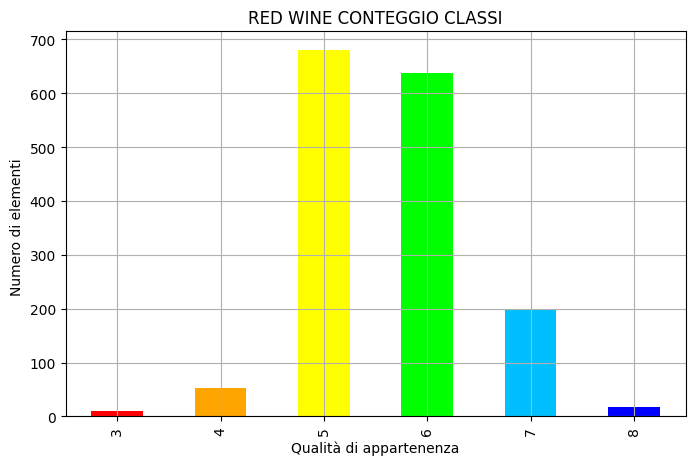

In [17]:
M1, N1 = red_wine.shape
class_cont_freq = pd.concat([red_wine['quality'].value_counts(), red_wine['quality'].value_counts()/M1], axis=1)
class_cont_freq.columns = ['counts', 'freq.']  
class_cont_freq.index.name = 'class'
class_cont_freq.sort_values('class', inplace=True)

display(class_cont_freq)

plt.figure()
class_cont_freq['counts'].plot.bar(figsize=(8,5), color=['red', 'orange', 'yellow', 'lime', 'deepskyblue', 'blue'])
plt.title('RED WINE CONTEGGIO CLASSI')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()
plt.show()

# PROBLEMA BINARIO

Ho diviso il problema di multiclassificazione in un problema binario accorpando le classi.

In [18]:
red_wine_copy = red_wine.copy()
red_wine_copy['quality'].replace([3, 4, 5], value=0, inplace=True)
red_wine_copy['quality'].replace([6, 7, 8], value=1, inplace=True)

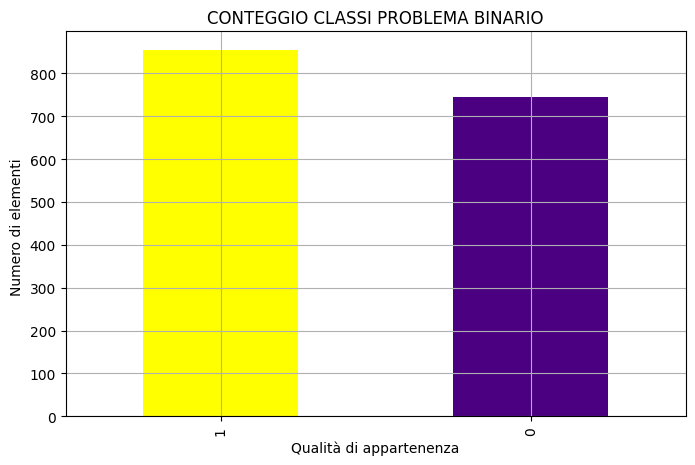

In [19]:
plt.figure()
red_wine_copy['quality'].value_counts().plot.bar(figsize=(8,5), color=['yellow', 'indigo'])
plt.title('CONTEGGIO CLASSI PROBLEMA BINARIO')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()

# CREAZIONE TRAINING, VALIDATION E TEST SET

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [21]:
X = red_wine_copy.drop('quality', axis=1).values
y = red_wine_copy['quality'].values
y_nomi_classe = ['classe 0', 'classe 1']

random_state = 20210526
test_p = 0.5
val_p = 0.4
indices = np.arange(X.shape[0])

ind_train, ind_test = train_test_split(indices, test_size=test_p, random_state=random_state, shuffle=True)
ind_train, ind_val = train_test_split(ind_train, test_size=val_p, random_state=random_state, shuffle=True)

# GRID SEARCH

In [22]:
import shap
from joblib import Parallel, delayed

Fitting 1 folds for each of 60 candidates, totalling 60 fits


Using 479 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 560/560 [9:49:21<00:00, 63.14s/it]     


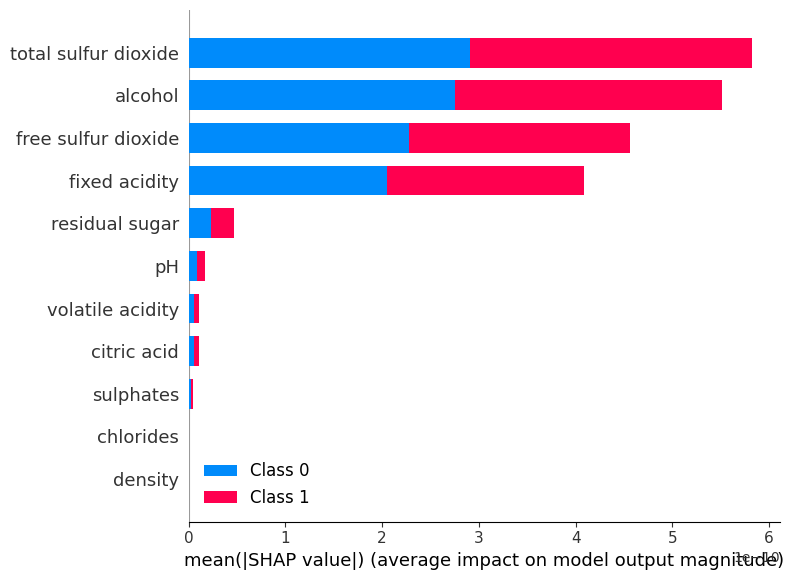

In [23]:
n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]),verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])

X_copy = red_wine_copy.drop('quality', axis=1)
# Get the SVM model from the pipeline
svm_model = best_model.named_steps['svc']

# Create the shap.KernelExplainer using the SVM model and the training data
explainer = shap.KernelExplainer(svm_model.predict_proba, X_copy.iloc[ind_train, :])

# Generate SHAP values for a sample of the dataset
X_test = X_copy.iloc[ind_test]
y_test = red_wine_copy['quality']
y_test = y_test.iloc[ind_test]

from sklearn.model_selection import StratifiedShuffleSplit

# Split the test set using stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)
test_indices = next(sss.split(X_test, y_test))[1]


sample = X_copy.iloc[test_indices, :]  # assuming X is a pandas DataFrame
shap_values = explainer.shap_values(sample)

# Visualize the SHAP values
shap.summary_plot(shap_values, sample)

In [24]:
n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(class_weight='balanced'))])
hparameters = {'svc__kernel':ker_list, 'svc__C':C_list, 'svc__gamma':gamma_list}

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]),verbose=True)
svm_gs.fit(X, y)

Fitting 1 folds for each of 60 candidates, totalling 60 fits


GridSearchCV(cv=<zip object at 0x00000221C125AEC0>,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.25, 0.5, 1, 2, 4],
                         'svc__gamma': [0.18181818181818182,
                                        0.09090909090909091,
                                        0.06060606060606061],
                         'svc__kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             return_train_score=True, scoring='f1_weighted', verbose=True)

In [25]:
df_results = pd.DataFrame(svm_gs.cv_results_)

display(df_results.sort_values(['rank_test_score'], ascending=True))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
40,0.008625,0.0,0.011034,0.0,2,0.090909,rbf,"{'svc__C': 2, 'svc__gamma': 0.0909090909090909...",0.768497,0.768497,0.0,1,0.834984,0.834984,0.0
24,0.008475,0.0,0.012753,0.0,1,0.181818,rbf,"{'svc__C': 1, 'svc__gamma': 0.1818181818181818...",0.762500,0.762500,0.0,2,0.853805,0.853805,0.0
56,0.007160,0.0,0.010109,0.0,4,0.060606,rbf,"{'svc__C': 4, 'svc__gamma': 0.0606060606060606...",0.759185,0.759185,0.0,3,0.835073,0.835073,0.0
52,0.018218,0.0,0.013426,0.0,4,0.090909,rbf,"{'svc__C': 4, 'svc__gamma': 0.0909090909090909...",0.759034,0.759034,0.0,4,0.853656,0.853656,0.0
16,0.010148,0.0,0.009959,0.0,0.5,0.090909,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.09090909090909...",0.753354,0.753354,0.0,5,0.797576,0.797576,0.0
0,0.019911,0.0,0.012907,0.0,0.25,0.181818,rbf,"{'svc__C': 0.25, 'svc__gamma': 0.1818181818181...",0.753180,0.753180,0.0,6,0.805888,0.805888,0.0
36,0.011987,0.0,0.012504,0.0,2,0.181818,rbf,"{'svc__C': 2, 'svc__gamma': 0.1818181818181818...",0.752775,0.752775,0.0,7,0.880899,0.880899,0.0
20,0.008185,0.0,0.011258,0.0,0.5,0.060606,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.06060606060606...",0.750264,0.750264,0.0,8,0.778679,0.778679,0.0
12,0.009233,0.0,0.013199,0.0,0.5,0.181818,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.18181818181818...",0.747110,0.747110,0.0,9,0.828829,0.828829,0.0
32,0.009504,0.0,0.012375,0.0,1,0.060606,rbf,"{'svc__C': 1, 'svc__gamma': 0.0606060606060606...",0.744020,0.744020,0.0,10,0.799679,0.799679,0.0


In [26]:
# Calcolo delle predizioni sul test set.
# Nomi delle variabili:
#
# y_pred_train: vettore delle predizioni sul training;
# y_true_train: vettore dei target "veri" del training set;
# y_pred_val: vettore delle predizioni sul validation;
# y_true_val: vettore dei target "veri" del validation set;
#
# y_pred: vettore delle predizioni sul test;
# y_true: vettore dei target "veri" del test set

# Ri-addestramento della miglior SVM
svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])
model = svm_gs.best_estimator_
import shap
shap_values = shap.Explainer(model, data=X[ind_train, :])
shap.summary_plot(shap_values, X[ind_train, :], plot_type="bar")

y_pred_train = svm_gs.best_estimator_.predict(X[ind_train, :])
y_true_train = y[ind_train]
y_pred_val = svm_gs.best_estimator_.predict(X[ind_val, :])
y_true_val = y[ind_val]

y_pred = svm_gs.best_estimator_.predict(X[ind_test, :])
y_true = y[ind_test]

acc_train = svm_gs.best_estimator_.score(X[ind_train, :], y_true_train)
prec_train = precision_score(y_true_train, y_pred_train, average='weighted')
rec_train = recall_score(y_true_train, y_pred_train, average='weighted')
f1_train = f1_score(y_true_train, y_pred_train, average='weighted')

acc_val = svm_gs.best_estimator_.score(X[ind_val, :], y_true_val)
prec_val = precision_score(y_true_val, y_pred_val, average='weighted')
rec_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

acc = svm_gs.best_estimator_.score(X[ind_test, :], y_true)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_train, acc_val, acc], 
                        'Precision': [prec_train, prec_val, prec], 
                        'Recall': [rec_train, rec_val, rec],
                        'F1': [f1_train, f1_val, f1]
                       },
                      index=['training', 'validation', 'test'])
cmat = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_)
cmat_norm_true = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='true')
cmat_norm_pred = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='pred')

df_cmat = pd.DataFrame(cmat, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_true = pd.DataFrame(cmat_norm_true, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_pred = pd.DataFrame(cmat_norm_pred, columns=y_nomi_classe, index=y_nomi_classe)

display(df_perf)
display(df_cmat)
display(df_cmat_norm_true)
display(df_cmat_norm_pred)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=2, class_weight='balanced', gamma=0.09090909090909091))])

In [ ]:
M1, N1 = red_wine.loc[ind_train+1, ['quality']].shape
M2, N2 = red_wine.loc[ind_test+1, ['quality']].shape
M3, N3 = red_wine.loc[ind_test+1, ['quality']].shape

class_cont_freq_tr = pd.concat([red_wine.loc[ind_train+1, ['quality']].value_counts(), red_wine.loc[ind_train+1, ['quality']].value_counts()/M1], axis=1)
class_cont_freq_tr.columns = ['counts', 'freq.']  
class_cont_freq_tr.index.names = ['class']
class_cont_freq_tr.sort_values('class', inplace=True)

class_cont_freq_te = pd.concat([red_wine.loc[ind_test+1, ['quality']].value_counts(), red_wine.loc[ind_test+1, ['quality']].value_counts()/M2], axis=1)
class_cont_freq_te.columns = ['counts', 'freq.']  
class_cont_freq_te.index.names = ['class']
class_cont_freq_te.sort_values('class', inplace=True)

class_cont_freq_va = pd.concat([red_wine.loc[ind_val+1, ['quality']].value_counts(), red_wine.loc[ind_val+1, ['quality']].value_counts()/M3], axis=1)
class_cont_freq_va.columns = ['counts', 'freq.']  
class_cont_freq_va.index.names = ['class']
class_cont_freq_va.sort_values('class', inplace=True)

display(class_cont_freq_tr)
display(class_cont_freq_te)
display(class_cont_freq_va)


In [ ]:
def subset_sum(numbers, target):
    """
    Find which numbers in a list sum up to a certain number.

    Args:
    numbers (list of tuples): A list of tuples, where each tuple contains a string and an integer.
    target (int): The target sum.

    Returns:
    A list of strings that correspond to the integers that sum up to the target number, 
    or an empty list if no such subset exists.
    """
    if target == 0:
        return []
    elif not numbers:
        return None
    else:
        # Try including the first number in the sum
        include = subset_sum(numbers[1:], target - numbers[0][1])
        if include is not None:
            return [numbers[0][0]] + include
        # Try excluding the first number from the sum
        exclude = subset_sum(numbers[1:], target)
        if exclude is not None:
            return exclude
        # If neither case works, return None
        return None
    
numbers = [
    ("PROSC.CCTTO CUB", 2.09),
    ("PASTA CCNAD", 0.75),
    ("CRACKER CONAD", 1.29),
    ("PASTA CCNAD", 0.75),
    ("FINOCCHI CPQ", 1.12),
    ("SACCHET10 BIO CONAD", 0.02),
    ("PANNA CLCINA CONAD 3", 1.95),
    ("SFOGLIATA OLIO CONAD", 1.15),
    ("RISO COMD BASM", 2.10),
    ("MACINATC DI SUINO", 3.07),
    ("MACINATC PER RAGT B", 5.23),
    ("SHOPPER BIO MEDIO CO", 0.10),
    ("SHOPPER BIO MEDIO W", 0.10),
    ("SPINACI BUSTA", 2.64),
    ("SOVRAC.FOLLO CONVEN.", 7.46),
    ("BRACIOLE SUINO CONF,", 4.98),
    ("PASSATA CLASSICA CON", 0.89),
    ("PATATE 40+ CPQ 1.5Kg", 1.99),
    ("MELE PIhOVA", 3.03),
    ("NUTELLA #", 5.19),
    ("CONFETTLRA EX.ALBICO", 1.29),
    ("BROCCOLO DI CAV", 2.13),
    ("UOVA MECIEx10 TERRA", 2.35),
    ("BANANE CPQ", 1.72),
    ("SACCHETTO BIO CONAD", 0.02),
    ("ZUCCHINE LUNGHE", 0.76),
    ("SACCHETTO BIO CONAD", 0.02),
    ("RIC.CONPD 250 g", 0.99),
    ("POM.CILIEGINO", 2.13),
    ("FARINA CONAD 00", 0.85),
    ("ROBIOLA CONAD 2", 2.29),
    ("LATTE PE CONAD", 0.59)
]

target = 31.45
result = subset_sum(numbers, target)
print(result)

['PROSC.CCTTO CUB', 'PASTA CCNAD', 'CRACKER CONAD', 'PASTA CCNAD', 'FINOCCHI CPQ', 'SACCHET10 BIO CONAD', 'PANNA CLCINA CONAD 3', 'SFOGLIATA OLIO CONAD', 'RISO COMD BASM', 'MACINATC DI SUINO', 'MACINATC PER RAGT B', 'SHOPPER BIO MEDIO CO', 'SHOPPER BIO MEDIO W', 'SPINACI BUSTA', 'PASSATA CLASSICA CON', 'PATATE 40+ CPQ 1.5Kg', 'BROCCOLO DI CAV', 'SACCHETTO BIO CONAD', 'ZUCCHINE LUNGHE', 'SACCHETTO BIO CONAD', 'RIC.CONPD 250 g', 'ROBIOLA CONAD 2']
